## Import Libraries and Load the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
 !unzip '/content/drive/MyDrive/Colab Notebooks/Dataset/Malnutri.zip'

Archive:  /content/drive/MyDrive/Colab Notebooks/Dataset/Malnutri.zip
   creating: Dataset/
   creating: Dataset/Nitrogen(N)/
  inflating: Dataset/Nitrogen(N)/untitled-1.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-10.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-100.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-101.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-102.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-103.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-104.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-105.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-106.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-107.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-108.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-109.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-11.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-110.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-111.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-112.JPG  
  inflating: Dataset/Nitrogen(N)/untitled-113.

## Exploring the Dataset

In [ ]:
import pathlib
import os
data_dir = '/content/Dataset'
data_dir = pathlib.Path(data_dir)

In [ ]:
print(os.listdir('/content/Dataset'))

['Phosphorus(P)', 'Nitrogen(N)', 'Potassium(K)']


In [ ]:
classes = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']

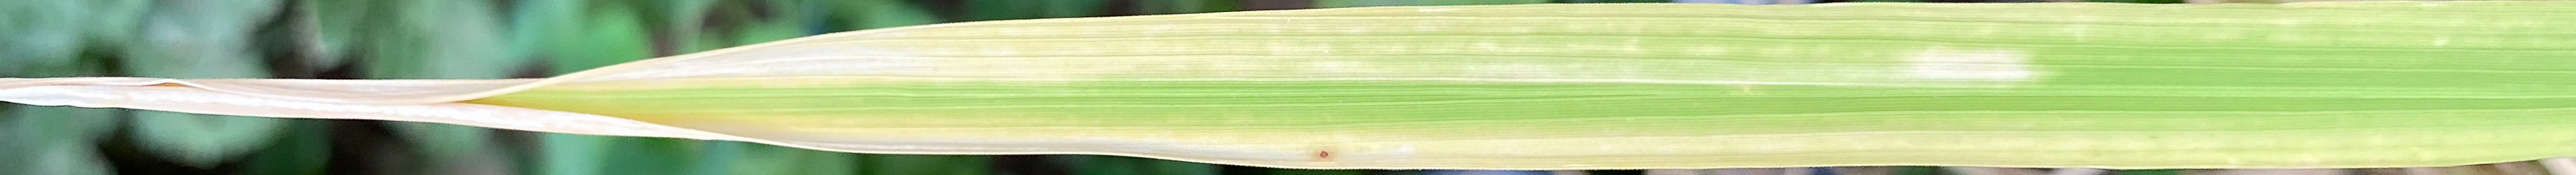

In [ ]:
import PIL
N = list(data_dir.glob('Nitrogen(N)/*'))
PIL.Image.open(str(N[0]))

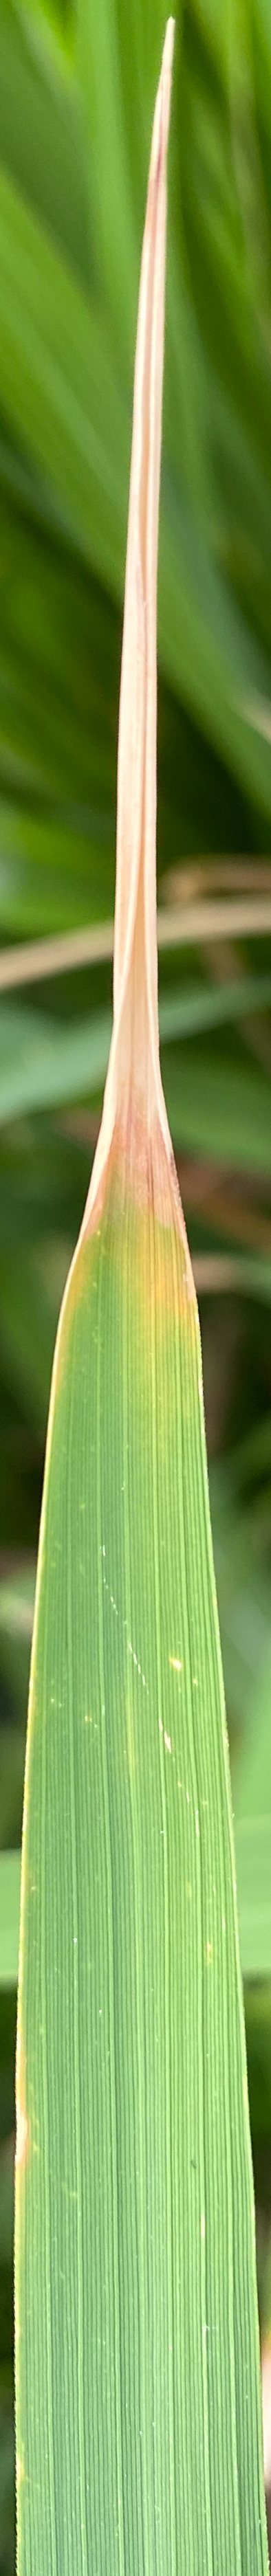

In [ ]:
P = list(data_dir.glob('Phosphorus(P)/*'))
PIL.Image.open(str(P[0]))

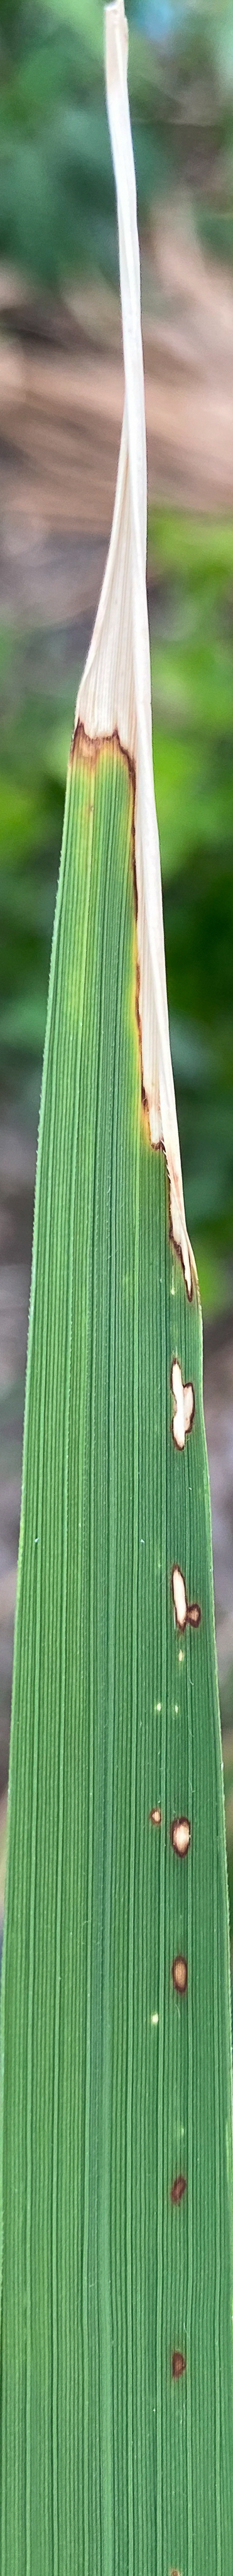

In [ ]:
K = list(data_dir.glob('Potassium(K)/*'))
PIL.Image.open(str(K[0]))

In [ ]:
import cv2
N1 = cv2.imread('/content/Dataset/Nitrogen(N)/untitled-1.JPG')
print(N1.shape)
P1 = cv2.imread('/content/Dataset/Phosphorus(P)/IMG_3784.JPG')
print(P1.shape)
K1 = cv2.imread('/content/Dataset/Potassium(K)/untitled-1.JPG')
print(K1.shape)

(3834, 310, 3)
(3748, 417, 3)
(3796, 471, 3)


## Image Pre-processing

In [ ]:
from pathlib import Path
import cv2

def preprocess(destination_path,target_path):
  format_of_your_images = 'JPG'
  all_the_files = Path(destination_path).rglob(f'*.{format_of_your_images}')
  for f in all_the_files:
    p = cv2.imread(str(f))
    p = cv2.cvtColor(p, cv2.COLOR_BGR2HSV)
    p = cv2.medianBlur(p, 5)
    #  transformation
    cv2.imwrite(f'{target_path}/{f.name}', p)

In [ ]:
destination_path1 = "/content/Dataset/Nitrogen(N)"
target_path1 = "/content/Dataset/Nitrogen(N)"
preprocess(destination_path1, target_path1)

In [ ]:
destination_path2 = "/content/Dataset/Phosphorus(P)"
target_path2 = "/content/Dataset/Phosphorus(P)"
preprocess(destination_path2, target_path2)

In [ ]:
destination_path3 = "/content/Dataset/Potassium(K)"
target_path3 = "/content/Dataset/Potassium(K)"
preprocess(destination_path3, target_path3)

## Data Pre-processing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data_augment = ImageDataGenerator(rescale=1./255,
                                  zoom_range=0.2,
                                  shear_range=0.2,
                                  rotation_range=0,
                                  vertical_flip=True,
                                  horizontal_flip=True,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest',
                                  validation_split=0.2)

In [ ]:
train = data_augment.flow_from_directory(directory=data_dir,
                                         target_size = (256, 256),
                                         batch_size = 64,
                                         class_mode = 'categorical',
                                         shuffle = True,
                                         subset='training')

Found 801 images belonging to 3 classes.


In [ ]:
valid = data_augment.flow_from_directory(directory = data_dir,
                                         target_size = (256, 256),
                                         batch_size = 64,
                                         class_mode = 'categorical',
                                         shuffle = False,
                                         subset='validation')

Found 198 images belonging to 3 classes.


## Models

In [ ]:
from tensorflow.keras import callbacks
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense,BatchNormalization

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class Attention(Layer):
    def __init__(self, filters):
        super(Attention, self).__init__()
        self.filters = 64

        self.conv1 = tf.keras.layers.Conv2D(self.filters, kernel_size=3, activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(self.filters, kernel_size=3, activation='sigmoid', padding='same')

    def call(self, inputs):
        # extract features using convolutional layer
        features = self.conv1(inputs)

        # compute attention scores using sigmoid activation
        scores = self.conv2(features)

        # multiply input features with attention scores
        weighted_features = tf.multiply(features, scores)

        # return weighted features
        return weighted_features


In [ ]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Average
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

# Define the CNN model
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Attention(64))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    return model

# Define the number of models to ensemble
num_models = 3

# Create an ensemble of CNN models
models = []
for i in range(num_models):
    model = create_model((256,256,3), 3)
    models.append(model)

# Compile the models
for model in models:
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the models
for model in models:
    history = model.fit(train, validation_data=valid, epochs=80, batch_size=64)

# Define the ensemble model
ensemble_inputs = Input(shape=(256,256,3))
ensemble_outputs = [model(ensemble_inputs) for model in models]
ensemble_outputs = Average()(ensemble_outputs)
ensemble_model = Model(inputs=ensemble_inputs, outputs=ensemble_outputs)

Epoch 1/80
13/13 [==============================] - 54s 3s/step - loss: 1.1399 - accuracy: 0.3371 - val_loss: 1.0984 - val_accuracy: 0.3333
Epoch 2/80
13/13 [==============================] - 34s 3s/step - loss: 1.0983 - accuracy: 0.3446 - val_loss: 1.0980 - val_accuracy: 0.3333
Epoch 3/80
13/13 [==============================] - 35s 3s/step - loss: 1.0977 - accuracy: 0.3508 - val_loss: 1.0908 - val_accuracy: 0.3434
Epoch 4/80
13/13 [==============================] - 34s 3s/step - loss: 1.0643 - accuracy: 0.3783 - val_loss: 0.9792 - val_accuracy: 0.4949
Epoch 5/80
13/13 [==============================] - 39s 3s/step - loss: 0.9440 - accuracy: 0.5206 - val_loss: 1.0379 - val_accuracy: 0.5000
Epoch 6/80
13/13 [==============================] - 35s 3s/step - loss: 0.8602 - accuracy: 0.5743 - val_loss: 0.8364 - val_accuracy: 0.5606
Epoch 7/80
13/13 [==============================] - 33s 3s/step - loss: 0.8488 - accuracy: 0.5780 - val_loss: 0.8608 - val_accuracy: 0.4848
Epoch 8/80
13/13 [==

In [ ]:
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 3)            9905923     ['input_1[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 3)            9905923     ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 3)            9905923     ['input_1[0][0]']            

In [ ]:
ensemble_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
history = ensemble_model.fit(train, epochs=80, validation_data=valid)

Epoch 1/80
13/13 [==============================] - 47s 3s/step - loss: 0.3564 - accuracy: 0.8889 - val_loss: 0.5449 - val_accuracy: 0.7525
Epoch 2/80
13/13 [==============================] - 37s 3s/step - loss: 0.3184 - accuracy: 0.8777 - val_loss: 0.5835 - val_accuracy: 0.7626
Epoch 3/80
13/13 [==============================] - 37s 3s/step - loss: 0.3019 - accuracy: 0.8951 - val_loss: 0.7023 - val_accuracy: 0.7020
Epoch 4/80
13/13 [==============================] - 41s 3s/step - loss: 0.2706 - accuracy: 0.8901 - val_loss: 0.4911 - val_accuracy: 0.7828
Epoch 5/80
13/13 [==============================] - 38s 3s/step - loss: 0.2381 - accuracy: 0.9301 - val_loss: 0.4938 - val_accuracy: 0.8131
Epoch 6/80
13/13 [==============================] - 39s 3s/step - loss: 0.2710 - accuracy: 0.9014 - val_loss: 0.5508 - val_accuracy: 0.7828
Epoch 7/80
13/13 [==============================] - 39s 3s/step - loss: 0.3191 - accuracy: 0.8801 - val_loss: 0.4619 - val_accuracy: 0.8081
Epoch 8/80
13/13 [==

## Evaluation

In [ ]:
loss, accuracy = ensemble_model.evaluate(valid)

4/4 [==============================] - 7s 2s/step - loss: 0.4865 - accuracy: 0.8030


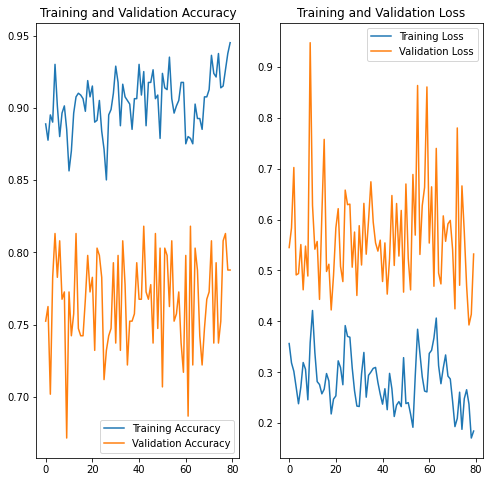

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(80)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
Y_pred = ensemble_model.predict(valid)
y_pred = np.argmax(Y_pred, axis=1)

4/4 [==============================] - 6s 1s/step


In [ ]:
from sklearn.metrics import classification_report
target_names = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']
print(classification_report(valid.classes, y_pred, target_names=target_names))

               precision    recall  f1-score   support

  Nitrogen(N)       0.86      1.00      0.92        66
Phosphorus(P)       0.74      0.82      0.78        66
 Potassium(K)       0.79      0.58      0.67        66

     accuracy                           0.80       198
    macro avg       0.80      0.80      0.79       198
 weighted avg       0.80      0.80      0.79       198



In [ ]:
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import sklearn.metrics
target_names = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)']
print(confusion_matrix(valid.classes, y_pred))#, target_names=target_names))

[[66  0  0]
 [ 2 54 10]
 [ 9 19 38]]


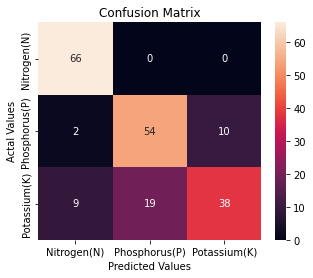

In [ ]:
import seaborn as sns
cm = confusion_matrix(valid.classes, y_pred)
cm_df = pd.DataFrame(cm,
                     index = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)'],
                     columns = ['Nitrogen(N)', 'Phosphorus(P)', 'Potassium(K)'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()